<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/NegEx_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install stanza
!pip install spacy_stanza
!pip install negspacy
!pip install negex
!pip install negfinder
!pip install negexpander
!pip install spacy-pipeline-negex



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 35.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for negspacy: filename=negspacy-1.0.4-py3-none-any.whl size=12535 sha256=5013b2aa2df1a829fa95ae70fd5d0a210476a4770227f0f3ad5eb5c018b6b5c9
  Stored in directory: /root/.cache/pip/wheels/15/31/f0/3a217aaedf320e4df653347cd6538f3648263b864c8e140853
Successfully built negspacy
ERROR: Could not find a version that satisfies the requirement negfinder (from versions: none)
ERROR: No matching distribution found for negfinder
ERROR: Could not find a version that satisfies the requirement negexpander (from versions: none)
ERROR: No matching distribution found for negexpander
ERROR: Could not find a version that satisfies the requirement spacy-pipe

In [4]:
import spacy # to build a nlp pipeline
import stanza # for named entity recognition
# this package wraps Stanza around Spacy, so that we can use Stanza in a spaCy pipeline.
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset # to customize negation terms
import pandas as pd
from tqdm.auto import tqdm
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

## **RBM #1 : NegEx**

In [6]:
# download and initialize a mimic pipeline with an i2b2 NER model
# stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [10]:
# nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT']})

ValueError: ignored

In [12]:
# nlp = spacy.load("en_core_sci_sm")
# import spacy
# from spacy.pipeline.negex import NegexComponent

# nlp = spacy.load("en_core_sci_sm")
# negex = NegexComponent(config={"chunk_prefix": ["no", "none", "not", "nor", "without"]})
# nlp.add_pipe(negex)


In [82]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model with the NegEx component
# nlp = spacy.load("en_core_sci_sm")
# nlp.add_pipe("negex", config={"chunk_prefix": ["no", "none", "not", "nor", "without","lack"]})

# Initialize an empty list to store predictions
predictions = []

# Iterate through the text in your DataFrame
for text in tqdm(df["doc_text_original"]):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether the sentence contains negations
    contains_negation = False

    # Iterate through sentences and check for negations
    for sent in doc.sents:
        for ent in sent.ents:
            if ent._.negex:
                contains_negation = True
                break

    # Determine the final classification (0 for negation, 1 for non-negation)
    prediction = 0 if contains_negation else 1
    predictions.append(prediction)

# Add the predictions as a new column in the dataframe
df['predicted'] = predictions


100%|██████████| 694/694 [00:09<00:00, 75.29it/s]


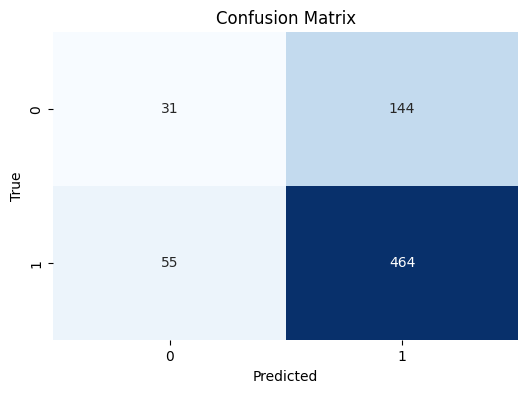

Accuracy: 0.71
Precision: 0.76
Recall: 0.89
F1 Score: 0.82


In [83]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [84]:
df[["label","selected_sentence"]]

,label,selected_sentence
0,yes,The Statfjord reservoir is overpressured (emw ...
1,yes,‘ The Brent reservoir is overpressured (emw 1...
2,yes,"» Finally, the core measurements have not been..."
3,yes,Also if the pressure in the Lower Unit should ...
4,yes,As regards the two pressures obtained in the w...
...,...,...
689,yes,"wide , ft , dull , yelwh t/t 20 % patchy grny/..."
690,yes,however no toc data avocet 1a and lorikeer 1 o...
691,yes,however no toc data avocet 1a and lorikeer 1 o...
692,yes,lower levels of these unknown compounds is not...


## **RBM #2 : Filter with negation terms**

In [14]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the negation terms
negation_terms = ["no", "none", "not", "nor", "without"]

# Your DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv("your_dataset.csv")

# Define a function for negation detection
def detect_negation(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether negation is detected
    negation_detected = False

    # Iterate through the tokens and check for negation terms
    for token in doc:
        if token.text.lower() in negation_terms:
            negation_detected = True
            break

    return negation_detected

# Apply the negation detection function to each text in the DataFrame
df["predicted"] = df["doc_text_original"].apply(detect_negation)

# Map the negation detection result to 0 (negation) or 1 (non-negation)
df["predicted"] = df["predicted"].astype(int)



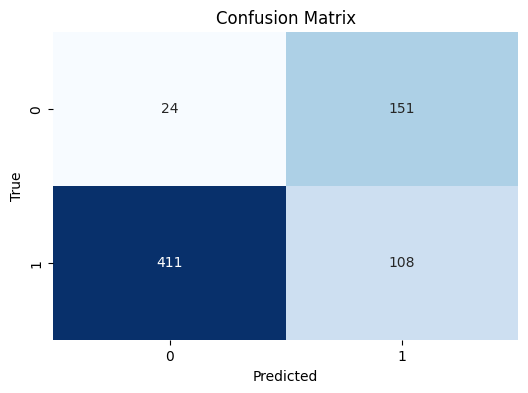

Accuracy: 0.19
Precision: 0.42
Recall: 0.21
F1 Score: 0.28


In [15]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **RBM #3 : Deterministic Option**

In [78]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

In [79]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer  # Import WordNetLemmatizer from nltk

nltk.download('punkt')
nltk.download('wordnet')

# Define the topics
topics = ["overpressure", "sand production", "oil show"]

# Define the negation terms
negation_terms = r'\b(?:no|none|not|nor|without)\b'

# Initialize a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize a dictionary to store selected sentences for each row
selected_sentences = {}

# Initialize a list to store predictions
predictions = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Convert the text to lowercase
    text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Initialize a list to store selected sentences for this row
    row_selected_sentences = []

    # Initialize a flag to check for both topic terms and negation terms
    both_detected = False

    for sentence in sentences:
        # Check if the sentence contains any of the specified topics
        if any(topic in sentence for topic in topics):
            # Check if the sentence contains negation terms
            if re.search(negation_terms, sentence):
                both_detected = True
                # Tokenize the sentence into words
                words = nltk.word_tokenize(sentence)

                # Lemmatize each word and join them back into a sentence
                lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in words])

                row_selected_sentences.append(lemmatized_sentence)

    # Join the selected sentences into a single string
    selected_sentence = ' '.join(row_selected_sentences)

    # If the selected_sentence is empty, copy the value from doc_text_original
    if not selected_sentence:
        selected_sentence = row['doc_text_original']

    # Store the selected sentences for this row in the dictionary
    selected_sentences[index] = selected_sentence

    # Determine the prediction (0 or 1) based on the presence of both topic terms and negation terms
    prediction = 0 if both_detected else 1
    predictions.append(prediction)

# Add the selected_sentences as a new column named 'selected_sentence' next to 'doc_text_original'
df.insert(df.columns.get_loc('doc_text_original') + 1, 'selected_sentence', df.index.map(selected_sentences))

# Add the predictions as a new column 'predicted'
df['predicted'] = predictions

df.columns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Index(['id', 'result_id', 'source_name', 'source_type', 'name', 'basin',
       'field_name', 'operator', 'longitude_decimal_degree',
       'longitude_degree', 'longitude_minutes', 'longitude_seconds',
       'longitude_direction', 'latitude_decimal_degree', 'latitude_degree',
       'latitude_minutes', 'latitude_seconds', 'latitude_direction', 'spud',
       'end_of_drill', 'northing', 'easting', 'kelly_bushing', 'well_type',
       'crs', 'derric_floor_elevation', 'rotary_table', 'total_depth', 'tvd',
       'tvdss', 'water_depth', 'play_segment', 'post_drill_conclusion',
       'tagged_wells_count', 'country', 'article_title', 'document_id',
       'document_title', 'page_number', 'dataset', 'label', 'label_code',
       'predicted', 'doc_text_original', 'selected_sentence'],
      dtype='object')

In [80]:
# Add the selected_sentence_labels list as a new column named 'label' next to 'selected_sentence'
# df.insert(df.columns.get_loc('selected_sentence') + 1, 'label_encoded', selected_sentence_labels)
# df["predicted"] = selected_sentence_labels

# Print the DataFrame with the 'label' column
df[['doc_text_original','selected_sentence','label_code','predicted']]

,doc_text_original,selected_sentence,label_code,predicted
0,The Statfjord reservoir is overpressured (emw ...,The Statfjord reservoir is overpressured (emw ...,1,1
1,‘ The Brent reservoir is overpressured (emw 1...,‘ The Brent reservoir is overpressured (emw 1...,1,1
2,"» Finally, the core measurements have not been...","» Finally, the core measurements have not been...",1,1
3,Also if the pressure in the Lower Unit should ...,Also if the pressure in the Lower Unit should ...,1,1
4,As regards the two pressures obtained in the w...,As regards the two pressures obtained in the w...,1,1
...,...,...,...,...
689,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"wide , ft , dull , yelwh t/t 20 % patchy grny/...",1,0
690,"""used to calculate the geochemical Altbough th...",however no toc data avocet 1a and lorikeer 1 o...,1,0
691,"""used to calculate the geochemical Altbough th...",however no toc data avocet 1a and lorikeer 1 o...,1,0
692,lower levels of these unknown compounds is not...,lower levels of these unknown compounds is not...,1,1


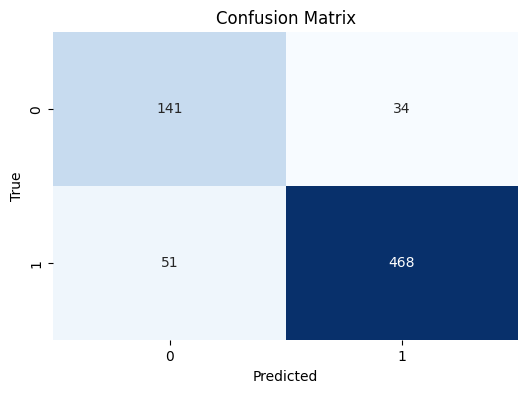

Accuracy: 0.88
Precision: 0.93
Recall: 0.90
F1 Score: 0.92


In [75]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [76]:
# Save the updated dataframe to a new CSV file
df.to_csv("your_updated_dataset.csv", index=False)

In [77]:
df

,id,result_id,source_name,source_type,name,basin,field_name,operator,longitude_decimal_degree,longitude_degree,...,article_title,document_id,document_title,page_number,dataset,label,label_code,predicted,doc_text_original,selected_sentence
0,0,0456b65e-a8c6-4781-921f-5866299ba7bb,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.41,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1,1,The Statfjord reservoir is overpressured (emw ...,
1,1,5449525e-55e3-4393-a0a7-8491131ac9ec,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.41,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1,1,‘ The Brent reservoir is overpressured (emw 1...,
2,2,5e2c63ca-eeae-4a67-9bec-0cbb1b019fdf,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.41,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,109,overpressure,yes,1,1,"» Finally, the core measurements have not been...",
3,3,a5673f0a-1d95-4200-84cd-bbbd61de1ddc,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.41,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1,1,Also if the pressure in the Lower Unit should ...,
4,4,3115cbd3-2cf1-4a95-b560-d943430459f3,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.41,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1,1,As regards the two pressures obtained in the w...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,96,75fa2376-4a24-411d-ba91-8a398018e980,SWAN 3-ST1,BONAPARTE,SWAN,BHP PETROLEUM PTY LTD,124.493210,NaN,NaN,NaN,...,Public Databases,0bec2748-41ba-4f21-8c30-65db23551d9f,Swan_3_3ST1_WCR_Interpretive_I00010109_Bonapar...,112,oil show,yes,1,0,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"wide , ft , dull , yelwh t/t 20 % patchy grny/..."
690,97,bb8150d5-7207-4e11-9c87-16b460e43610,LORIKEET-1,BONAPARTE,LORIKEET,BHP PETROLEUM PTY LTD,125.619232,NaN,NaN,NaN,...,Public Databases,5c445c91-3503-40f6-bfa3-87edb6bb6dfb,Lorikeet_1_WCR_Interpretative_Data_I00028852_B...,87,oil show,yes,1,0,"""used to calculate the geochemical Altbough th...",however no toc data avocet 1a and lorikeer 1 o...
691,98,bb8150d5-7207-4e11-9c87-16b460e43610,LORIKEET-1 ST-1,BONAPARTE,LORIKEET,BHP PETROLEUM PTY LTD,125.619232,NaN,NaN,NaN,...,Public Databases,5c445c91-3503-40f6-bfa3-87edb6bb6dfb,Lorikeet_1_WCR_Interpretative_Data_I00028852_B...,87,oil show,yes,1,0,"""used to calculate the geochemical Altbough th...",however no toc data avocet 1a and lorikeer 1 o...
692,99,888c2d05-ad64-4aed-b722-271d6d7cef02,MONTARA-1,BONAPARTE,MONTARA,BHP PETROLEUM PTY LTD,124.532920,NaN,NaN,NaN,...,Public Databases,9e575914-9f9f-44bb-a42b-ddec1da52b29,WCR_Interpretive_Data_I00028891.pdf,384,oil show,yes,1,1,lower levels of these unknown compounds is not...,
